# Probability
*All models are wrong, but some are useful*

### Probabilistic Model
Recall that Percy uses a probabilistic model in contrast to a categorical one. Now that we've gathered a nameset let's explore how this is implemented.


In [1]:
from scipy import stats
import numpy as np

# Loading our KeywordProcessor from the previous notebook
import pickle
with open(r'data/keyword_processor.pkl', 'rb') as fp:
    kp = pickle.load(fp)
    
names = kp.get_all_keywords()

For our purposes, each name can have two possible outcomes: male or female.

Therefore, we expect that the probability distribution will be a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution). Note that we will use the convention:

$Female = 1$

$Male = 0$

Using a Frequentist approach, we can calculate the probability of a person with a name being female in the below forumla:

$P(f) = n_{female}/(n_{female} + n_{male})$

A Python implementation is below

In [2]:
def get_prob_female(name, kp=kp):
    n_male, n_female = max(kp.extract_keywords(name), key=lambda x: sum(x))
    return n_female / (n_male + n_female)
    
print(get_prob_female("John"))
print(get_prob_female("Mary"))


0.004450805850750951
0.995639936876698


While this calculation is simple, it makes some overreaching assumptions. Namely, is assumes that we have sampled every "John" and every "Mary". In fact, according to the SSA, this is exactly the case. So why is this a problem?

There is an incredible amount of diversity in the world's first names. Further, the United States only represents roughly 5% of the world's population. So chances are for any given name, we will not have it in our database. Additionally, even if a name is present in our dataset, it only represents gender counts in the United States. Therefore, we cannot assume that our data is canonical!


### An Intuitive Approach
Sometimes it is useful to examine the extreme cases in our data to determine how we should proceed.

While we've determined that our name data is not entirely representative, we have not determined to what degree. Some examples:          

| Name  | N_Male    | N_Female | Total     | % Female |
|-------|-----------|----------|-----------|----------|
| James | 1,335,487 | 6,918    | 1,342,405 | 0.51%    |
| Jey   | 5         | 0        | 5         | 0%       |
| Jenis | 0         | 5        | 5         | 100%     |

If we use our Frequentist calculation, we can see where this breaks down with small record sizes. There are ways to handle small sample sizes but they are not ideal for our purposes. However, when the number of samples is sufficiently large, the calculation appears to be sensible.

What is needed is a method to convey our certainty in our probability calculation. This is where we can introduce

### The Bayesian Approach
![Bayesian](https://imgs.xkcd.com/comics/modified_bayes_theorem.png)

#### Contrasting Approaches
*Adapted from [Panos Ipeirotis](https://www.behind-the-enemy-lines.com/2008/01/are-you-bayesian-or-frequentist-or.html)*

---
You are flipping a (potentially weighted) coin. You are trying to ascertain the probability, $p$, of the coin coming up Heads. Tails is $1-p$.

After flipping the coin 10 times you count 7 Heads and 3 Tails. So, what is $p$?

##### Frequentist

$p = \frac{7}{10}$
 
$p= 0.7$

*The probability of Heads is 0.7 and the probability of Tails is $1 - 0.7 = 0.3$*

##### Bayesian
>A Bayesian approach, instead of considering only the maximum likelihood estimate for p, it would treat p as a random variable with its own distribution of possible values. The distribution can be defined by the existing evidence. The logic goes as follows. What is the probability of a given value of p, given the data?

We arrive at the conclusion that the prior distribution for $p$ can be modeled as a [Beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution). This requires us to solve for the [Beta function](https://en.wikipedia.org/wiki/Beta_function) to generate the distribution.

In this case our Beta function is described as:

$$Beta(p, 1 + 7, 1 +3) = Beta(p, 8, 5)$$


<IPython.core.display.Javascript object>


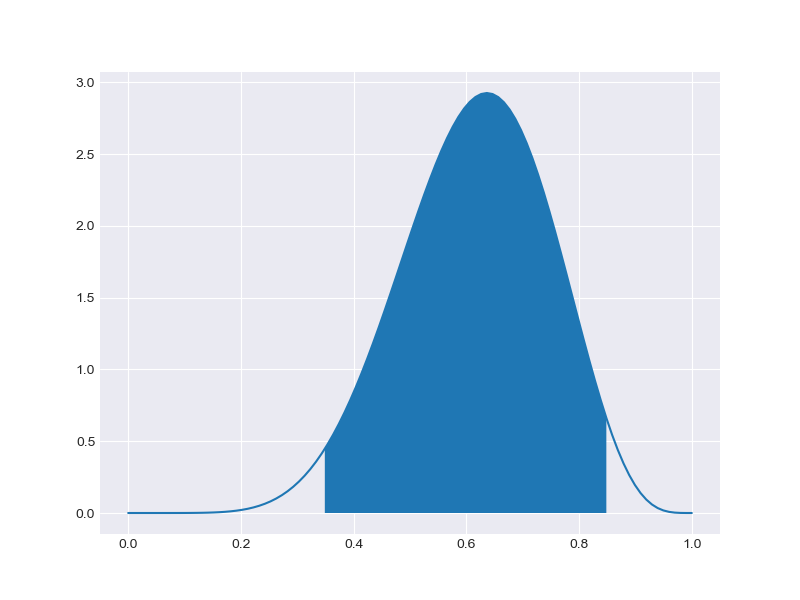

In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
p_beta = stats.beta(8, 5)
x = np.linspace(0, 1, 100)
pdf = [p_beta.pdf(i) for i in x]

# confidence interval
min_prob, max_prob = p_beta.interval(0.95)

# defining where to fill area under curve
fill_x = np.linspace(min_prob, max_prob, 100)
fill_y = [p_beta.pdf(i) for i in fill_x]

fig = plt.figure(figsize=(8, 6))

plt.plot(x, pdf)
plt.fill_between(fill_x, fill_y)
plt.show()


### Implementation

While we are trying to estimate $p$ for a coin in the above example, the same methods can be applied when 
estimating $p$ for a name. As a convention we treat $female = p$ and $male = (1-p)$

A Beta function looks like:

$$ Beta(p; \alpha, \beta)$$

Before we begin to determine $\alpha$ and $\beta$ we need to determine our [Prior](https://en.wikipedia.org/wiki/Prior_probability). 

#### Uninformative Prior
If we are operating under the assumption that a randomly chosen name is equally likely to be male or female, this is assumption is an Uninformative Prior. This is a special case of a Beta distribution, a [Beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution)

The Beta function for a Beta-binomial distribution is
$$Beta(p; \alpha=1, \beta=1)$$



Visualizing the distribution:

![Beta-binomial](https://raw.githubusercontent.com/estasney/PercyNB/master/notebooks/data/beta_binomial_pdf.png)     


#### Prior

If we have prior beliefs about our population, determining $\alpha$ and $\beta$ is much more complicated. Intuitively we know that if a name set is biased one way or another this affects our probabilities.

![Conditional Probability](https://imgs.xkcd.com/comics/conditional_risk.png)

**Example**
1. We are analyzing a set of names taken from a population the likelihood of a randomly chosen name being male or female is not equal.

2. We are 95% confident that the likelihood of a random name being female lies between the interval (0.6, 0.8)
    
In order to find the Beta distribution that fits this prior belief, we must determine $\alpha$ and $\beta$

Interestingly, there is no mathematical solution to this problem. We know that as the magnitude of $\alpha$ and $\beta$ increases our interval decreases.

![Beta](https://raw.githubusercontent.com/estasney/PercyNB/master/notebooks/data/beta.gif)                   
----

We also know that as $\alpha$ increases our distribution shifts towards 1.

The inverse is true of $\beta$, as it increases, our distribution shifts towards 0.

However, while we are aware of trends their magnitudes are highly variable.

##### Estimation
Currently, our approach uses pre-calculated 95% confidence intervals from all combinations of $\alpha$ and \$beta$ from 1 - 1000.

So long as the minimum and maximum for our prior belief interval are at least 0.05 apart, these population parameters can be accurately estimated. Estimating smaller intervals would require exponentially more calculations and would be infeasible.

          

### Trials
Now that we have a method in place for quantifying a name's probability we can explore how we will go about determining the outcome.

Recall that for our purposes, a name can be either male or female. Therefore, this is described as a [Binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution).
Further, since we are assuming that a name is equally likely to be male or female our distribution is described as a [Beta-binomial distribution](https://en.wikipedia.org/wiki/Beta-binomial_distribution).

Calculating the maximum likelihood is impractical. However, we can estimate it through simulation. We know from the [Central Limit theorem](https://en.wikipedia.org/wiki/Central_limit_theorem) that with a sufficient number of trials, we will approach the true maximum likelihood.

### Implementation

So far, our calculation steps look like this: 

Determine probability interval from name counts:
```python
beta_dist = stats.beta(alpha=(n_female +1), beta=(n_male + 1))
prob_interval = beta_dist.interval(0.95)
```

To run simulations we will need a function that returns 1 or 0. Additionally, we need to configure the function based on our probability interval.

Using `numpy`, we run two simulations, one with the minimum probability, the other with the maximum probability. By combining and taking the mean of these results we can arrive at the maximum likelihood.  

In [4]:
def make_name_simulation(prob_interval, n_trials):
    
    prob_min, prob_max = prob_interval
    min_result = np.random.binomial(1, prob_min, size=n_trials // 2)
    max_result = np.random.binomial(1, prob_max, size=n_trials // 2)
    results = np.concatenate([min_result, max_result])
    np.random.shuffle(results)
    return results

make_name_simulation((0.25, 0.75), 50000).mean()


0.50302

Why bother with running these simulations when clearly

$$\frac{.25 + .75}{2}=0.5$$

Is much simpler to compute?   

We explore the answer to this question in the next notebook.